In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample

# Step 1: Load the dataset
data = pd.read_csv('/Users/bishmaybarik/Library/CloudStorage/OneDrive-ShivNadarInstitutionofEminence/estimate_inc_risk/01_data/inrisk_data.csv')

# Step 2: Filter the data
filtered_data = data[
    (data['relation_with_hoh'] == 'HOH') &
    (data['gender'] == 'M') &
    (data['age_yrs'] > 25) &
    (data['age_yrs'] < 60)
]

# Step 3: Combine income variables to calculate total income
filtered_data['total_income'] = (
    filtered_data['inc_of_mem_frm_all_srcs'] + filtered_data['inc_of_mem_frm_wages']
)

# Step 4: Retain only rows with positive total_income
trimmed_data = filtered_data[filtered_data['total_income'] > 0]

# Step 5: Take the log of total income
trimmed_data['log_total_income'] = np.log(trimmed_data['total_income'])


In [3]:
import pandas as pd
import numpy as np

# Step 6: Initialize the interest_soc_group column
trimmed_data['interest_soc_group'] = np.nan

# Step 7: Replace values based on conditions
trimmed_data.loc[trimmed_data['caste_category'] == "SC", 'interest_soc_group'] = 1
trimmed_data.loc[trimmed_data['caste_category'] == "ST", 'interest_soc_group'] = 2
trimmed_data.loc[trimmed_data['caste_category'] == "OBC", 'interest_soc_group'] = 3
trimmed_data.loc[trimmed_data['religion'] == "Muslim", 'interest_soc_group'] = 4
trimmed_data.loc[
    (trimmed_data['religion'] == "Hindu") & 
    (trimmed_data['caste_category'].isin(["Intermediate Caste", "Upper Caste"])), 
    'interest_soc_group'
] = 5
trimmed_data.loc[trimmed_data['interest_soc_group'].isna(), 'interest_soc_group'] = 6

# Step 8: Define and apply labels
socgroup_labels = {
    1: "SC",
    2: "ST",
    3: "OBC",
    4: "Muslims",
    5: "Other Hindus",
    6: "Other Religions"
}

trimmed_data['interest_soc_group'] = trimmed_data['interest_soc_group'].astype(int)  # Convert to int for labeling
trimmed_data['interest_soc_group_label'] = trimmed_data['interest_soc_group'].map(socgroup_labels)

# The `trimmed_data` DataFrame now contains the `interest_soc_group` and its labeled version.


In [4]:
import statsmodels.api as sm
import numpy as np
from sklearn.utils import resample

# Initialize a dictionary to store results
results = {}

# Loop through each interest_soc_group in `trimmed_data`
for group in trimmed_data['interest_soc_group'].unique():
    # Filter the dataset for the current group
    group_data = trimmed_data[trimmed_data['interest_soc_group'] == group].copy()

    # Step 1: Regression to isolate residuals
    X = pd.get_dummies(group_data[['age_yrs', 'region_type']], drop_first=True)
    X = sm.add_constant(X).astype(float)  # Ensure compatibility

    y = group_data['log_total_income']
    model = sm.OLS(y, X, missing='drop').fit()
    group_data['residuals'] = model.resid

    # Step 2: Estimating Variance Components
    group_data['residuals_lagged'] = group_data.groupby(['hh_id', 'mem_id'])['residuals'].shift(1)
    residuals_data = group_data[['residuals', 'residuals_lagged']].dropna()

    sigma_residuals = residuals_data['residuals'].var()
    sigma_residuals_lagged = residuals_data['residuals_lagged'].var()
    cov_residuals = residuals_data.cov().iloc[0, 1]

    rho = cov_residuals / sigma_residuals_lagged
    sigma_eta_squared = sigma_residuals - rho**2 * sigma_residuals_lagged
    sigma_alpha_squared = sigma_residuals - sigma_eta_squared

    # Step 3: Bootstrapping for Confidence Intervals
    n_iterations = 500
    bootstrap_rho = []
    bootstrap_sigma_eta_squared = []
    bootstrap_sigma_alpha_squared = []

    for _ in range(n_iterations):
        sample = resample(residuals_data)

        sigma_residuals_sample = sample['residuals'].var()
        sigma_residuals_lagged_sample = sample['residuals_lagged'].var()
        cov_residuals_sample = sample.cov().iloc[0, 1]

        rho_sample = cov_residuals_sample / sigma_residuals_lagged_sample
        bootstrap_rho.append(rho_sample)

        sigma_eta_squared_sample = sigma_residuals_sample - rho_sample**2 * sigma_residuals_lagged_sample
        sigma_alpha_squared_sample = sigma_residuals_sample - sigma_eta_squared_sample

        bootstrap_sigma_eta_squared.append(sigma_eta_squared_sample)
        bootstrap_sigma_alpha_squared.append(sigma_alpha_squared_sample)

    rho_ci = (np.percentile(bootstrap_rho, 2.5), np.percentile(bootstrap_rho, 97.5))
    sigma_eta_ci = (np.percentile(bootstrap_sigma_eta_squared, 2.5), np.percentile(bootstrap_sigma_eta_squared, 97.5))
    sigma_alpha_ci = (np.percentile(bootstrap_sigma_alpha_squared, 2.5), np.percentile(bootstrap_sigma_alpha_squared, 97.5))

    # Store results for the group
    results[group] = {
        "rho": rho,
        "rho_ci": rho_ci,
        "sigma_eta_squared": sigma_eta_squared,
        "sigma_eta_ci": sigma_eta_ci,
        "sigma_alpha_squared": sigma_alpha_squared,
        "sigma_alpha_ci": sigma_alpha_ci
    }

# Step 4: Output results
for group, result in results.items():
    print(f"Group {group}:")
    print(f"Estimated rho (persistence of income shocks): {result['rho']:.4f}")
    print(f"95% CI for rho: {result['rho_ci']}")
    print(f"Estimated variance of transitory shocks (sigma_eta^2): {result['sigma_eta_squared']:.4f}")
    print(f"95% CI for sigma_eta^2: {result['sigma_eta_ci']}")
    print(f"Estimated variance of persistent shocks (sigma_alpha^2): {result['sigma_alpha_squared']:.4f}")
    print(f"95% CI for sigma_alpha^2: {result['sigma_alpha_ci']}")
    print()


/var/folders/wm/lp427bhn21l7_b9826wl131h0000gn/T/ipykernel_2197/402221494.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['residuals'] = model.resid
/var/folders/wm/lp427bhn21l7_b9826wl131h0000gn/T/ipykernel_2197/402221494.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['residuals_lagged'] = group_data.groupby(['hh_id', 'mem_id'])['residuals'].shift(1)
/var/folders/wm/lp427bhn21l7_b9826wl131h0000gn/T/ipykernel_2197/402221494.py:20: SettingWithCopyWarning: 
A value is trying t

Group 4:
Estimated rho (persistence of income shocks): 0.9388976843030356
95% CI for rho: (0.9373419413872706, 0.9402447774313302)
Estimated variance of transitory shocks (sigma_eta^2): 0.055492353437774644
95% CI for sigma_eta^2: (0.05465313750329553, 0.05650580625412221)
Estimated variance of persistent shocks (sigma_alpha^2): 0.40875027547555154
95% CI for sigma_alpha^2: (0.40636228138388586, 0.4113314201315822)

Group 6:
Estimated rho (persistence of income shocks): 0.9508053672888014
95% CI for rho: (0.947550157925631, 0.9541960459637507)
Estimated variance of transitory shocks (sigma_eta^2): 0.06400975615523208
95% CI for sigma_eta^2: (0.06052634565766512, 0.06742065827531782)
Estimated variance of persistent shocks (sigma_alpha^2): 0.6449699977424038
95% CI for sigma_alpha^2: (0.6381664930511987, 0.6511044871109022)

Group 3:
Estimated rho (persistence of income shocks): 0.9413681045634548
95% CI for rho: (0.9406354215643897, 0.9421036383230148)
Estimated variance of transitory 

In [5]:
import os

# File path to save the results
file_path = "/Users/bishmaybarik/Library/CloudStorage/OneDrive-ShivNadarInstitutionofEminence/estimate_inc_risk/03_results/caste_groups.txt"

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Writing results to the file
with open(file_path, "w") as file:
    for group, result in results.items():
        file.write(f"Group {group}:\n")
        file.write(f"Estimated rho (persistence of income shocks): {result['rho']:.4f}\n")
        file.write(f"95% CI for rho: ({result['rho_ci'][0]:.4f}, {result['rho_ci'][1]:.4f})\n")
        file.write(f"Estimated variance of transitory shocks (sigma_eta^2): {result['sigma_eta_squared']:.4f}\n")
        file.write(f"95% CI for sigma_eta^2: ({result['sigma_eta_ci'][0]:.4f}, {result['sigma_eta_ci'][1]:.4f})\n")
        file.write(f"Estimated variance of persistent shocks (sigma_alpha^2): {result['sigma_alpha_squared']:.4f}\n")
        file.write(f"95% CI for sigma_alpha^2: ({result['sigma_alpha_ci'][0]:.4f}, {result['sigma_alpha_ci'][1]:.4f})\n")
        file.write("\n")


In [7]:
import os

# Labels for the social groups
socgroup_labels = {
    1: "SC Group",
    2: "ST Group",
    3: "OBC Group",
    4: "Muslims Group",
    5: "Other Hindus Group",
    6: "Other Religions Group"
}

# File path to save the results with updated labels
file_path = "/Users/bishmaybarik/Library/CloudStorage/OneDrive-ShivNadarInstitutionofEminence/estimate_inc_risk/03_results/caste_groups_labeled.txt"

# Ensure the directory exists
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Writing results to the file with updated labels
with open(file_path, "w") as file:
    for group, result in results.items():
        # Replace group number with the corresponding label
        group_label = socgroup_labels.get(int(group), f"Group {group}")  # Convert group to int for lookup
        file.write(f"{group_label}:\n")
        file.write(f"Estimated rho (persistence of income shocks): {result['rho']:.4f}\n")
        file.write(f"95% CI for rho: ({result['rho_ci'][0]:.4f}, {result['rho_ci'][1]:.4f})\n")
        file.write(f"Estimated variance of transitory shocks (sigma_eta^2): {result['sigma_eta_squared']:.4f}\n")
        file.write(f"95% CI for sigma_eta^2: ({result['sigma_eta_ci'][0]:.4f}, {result['sigma_eta_ci'][1]:.4f})\n")
        file.write(f"Estimated variance of persistent shocks (sigma_alpha^2): {result['sigma_alpha_squared']:.4f}\n")
        file.write(f"95% CI for sigma_alpha^2: ({result['sigma_alpha_ci'][0]:.4f}, {result['sigma_alpha_ci'][1]:.4f})\n")
        file.write("\n")


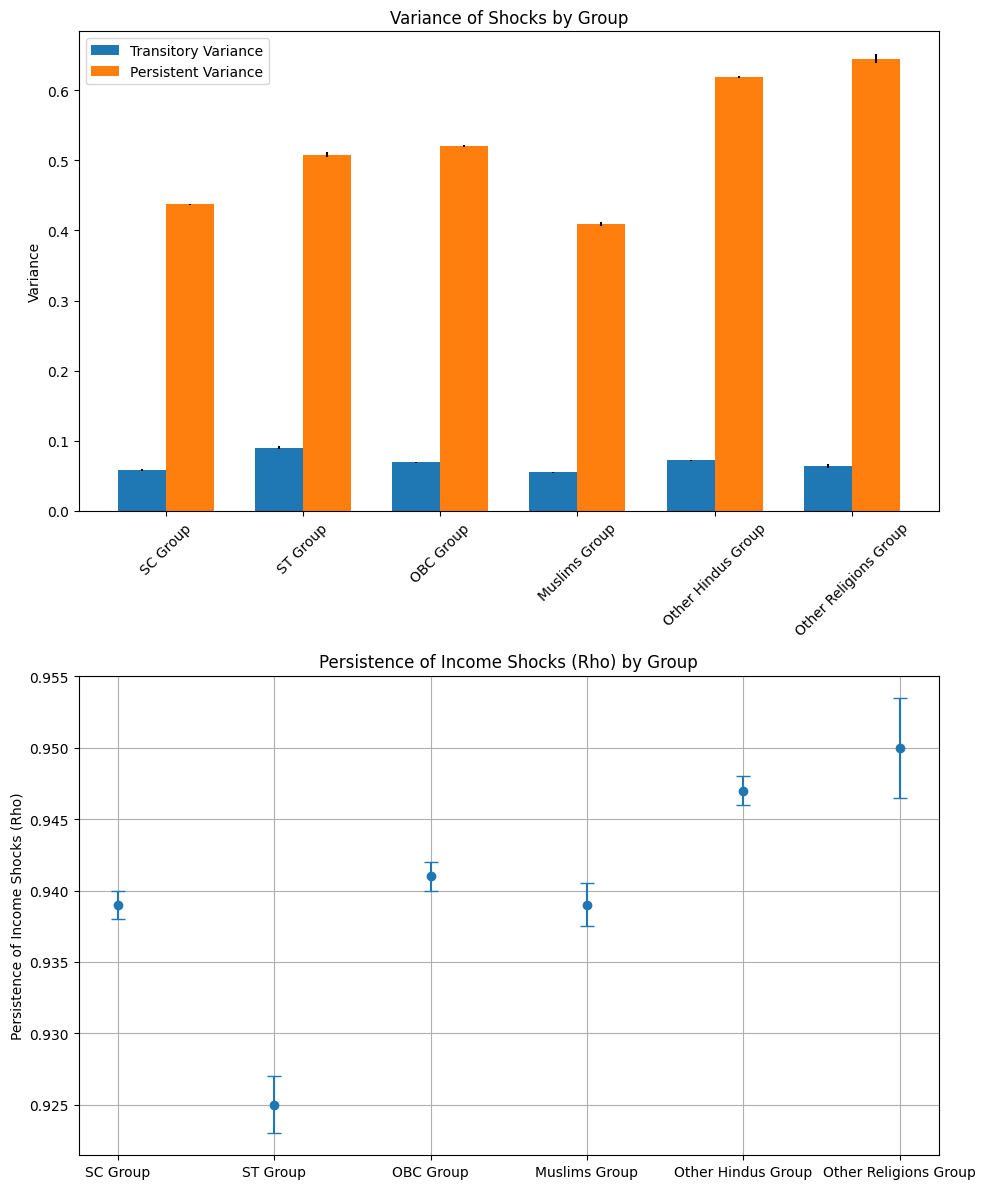

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data structure (replace with your actual data)
groups = ["SC Group", "ST Group", "OBC Group", "Muslims Group", "Other Hindus Group", "Other Religions Group"]
rho = [0.939, 0.925, 0.941, 0.939, 0.947, 0.950]
rho_ci = [(0.938, 0.940), (0.923, 0.927), (0.940, 0.942), (0.937, 0.940), (0.946, 0.948), (0.947, 0.954)]
sigma_eta_squared = [0.058, 0.090, 0.069, 0.055, 0.072, 0.064]
sigma_eta_ci = [(0.057, 0.059), (0.088, 0.092), (0.068, 0.070), (0.054, 0.056), (0.071, 0.073), (0.061, 0.067)]
sigma_alpha_squared = [0.437, 0.508, 0.520, 0.409, 0.619, 0.645]
sigma_alpha_ci = [(0.436, 0.438), (0.504, 0.511), (0.519, 0.522), (0.406, 0.411), (0.617, 0.621), (0.638, 0.651)]

# Convert CI to error bars
rho_errors = np.array([(high - low) / 2 for low, high in rho_ci])
sigma_eta_errors = np.array([(high - low) / 2 for low, high in sigma_eta_ci])
sigma_alpha_errors = np.array([(high - low) / 2 for low, high in sigma_alpha_ci])

x = np.arange(len(groups))

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Subplot 1: Bar chart for variances
width = 0.35
ax[0].bar(x - width/2, sigma_eta_squared, width, yerr=sigma_eta_errors, label="Transitory Variance")
ax[0].bar(x + width/2, sigma_alpha_squared, width, yerr=sigma_alpha_errors, label="Persistent Variance")
ax[0].set_xticks(x)
ax[0].set_xticklabels(groups, rotation=45)
ax[0].set_ylabel("Variance")
ax[0].set_title("Variance of Shocks by Group")
ax[0].legend()

# Subplot 2: Scatter plot for rho
ax[1].errorbar(groups, rho, yerr=rho_errors, fmt='o', label="Estimated Rho", capsize=5)
ax[1].set_ylabel("Persistence of Income Shocks (Rho)")
ax[1].set_title("Persistence of Income Shocks (Rho) by Group")
ax[1].grid(True)

# Save the plot
output_path = "/Users/bishmaybarik/Library/CloudStorage/OneDrive-ShivNadarInstitutionofEminence/estimate_inc_risk/03_results/results.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300)  # Save with high resolution
plt.show()


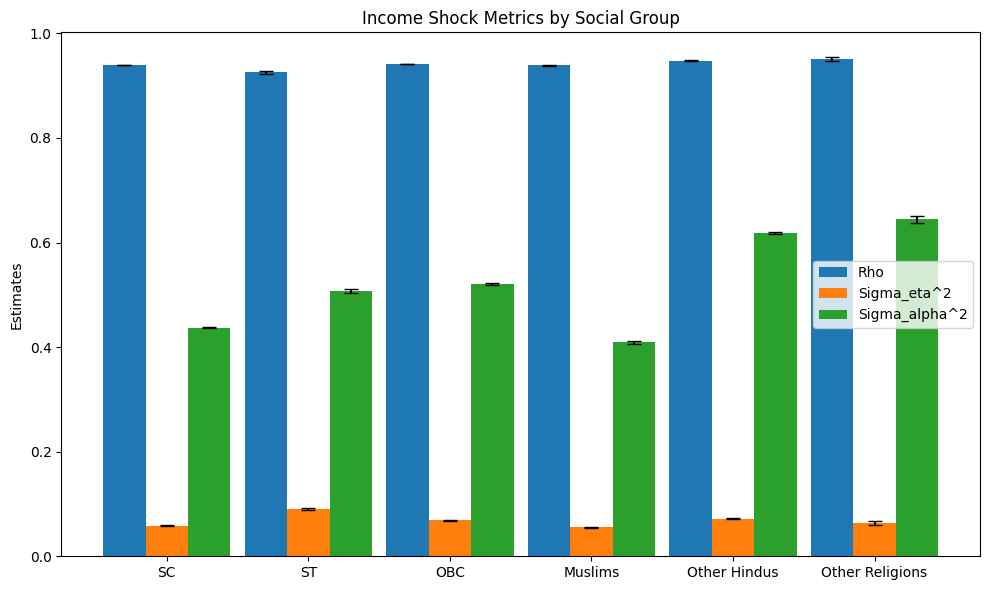

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
groups = ["SC", "ST", "OBC", "Muslims", "Other Hindus", "Other Religions"]
rho = [0.9394, 0.9253, 0.9414, 0.9389, 0.9473, 0.9508]
rho_ci = [(0.9386, 0.9403), (0.9231, 0.9273), (0.9406, 0.9421), (0.9373, 0.9402), (0.9466, 0.9482), (0.9476, 0.9542)]
sigma_eta_squared = [0.0583, 0.0901, 0.0689, 0.0555, 0.0719, 0.0640]
sigma_eta_ci = [(0.0576, 0.0589), (0.0882, 0.0920), (0.0683, 0.0696), (0.0547, 0.0565), (0.0711, 0.0728), (0.0605, 0.0674)]
sigma_alpha_squared = [0.4371, 0.5076, 0.5205, 0.4088, 0.6186, 0.6450]
sigma_alpha_ci = [(0.4356, 0.4387), (0.5041, 0.5113), (0.5191, 0.5219), (0.4064, 0.4113), (0.6167, 0.6205), (0.6382, 0.6511)]

# Bar plot with error bars
x = np.arange(len(groups))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

# Plot rho
rho_lower_error = [r - ci[0] for r, ci in zip(rho, rho_ci)]
rho_upper_error = [ci[1] - r for r, ci in zip(rho, rho_ci)]
ax.bar(x - width, rho, width, label="Rho", yerr=[rho_lower_error, rho_upper_error], capsize=5)

# Plot sigma_eta_squared
sigma_eta_lower_error = [s - ci[0] for s, ci in zip(sigma_eta_squared, sigma_eta_ci)]
sigma_eta_upper_error = [ci[1] - s for s, ci in zip(sigma_eta_squared, sigma_eta_ci)]
ax.bar(x, sigma_eta_squared, width, label="Sigma_eta^2", yerr=[sigma_eta_lower_error, sigma_eta_upper_error], capsize=5)

# Plot sigma_alpha_squared
sigma_alpha_lower_error = [s - ci[0] for s, ci in zip(sigma_alpha_squared, sigma_alpha_ci)]
sigma_alpha_upper_error = [ci[1] - s for s, ci in zip(sigma_alpha_squared, sigma_alpha_ci)]
ax.bar(x + width, sigma_alpha_squared, width, label="Sigma_alpha^2", yerr=[sigma_alpha_lower_error, sigma_alpha_upper_error], capsize=5)

# Labels and Legend
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_ylabel("Estimates")
ax.set_title("Income Shock Metrics by Social Group")
ax.legend()

plt.tight_layout()
plt.show()
